In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

from tcr_embedding.utils_preprocessing import stratified_group_shuffle_split, group_shuffle_split
from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.evaluation.kNN import run_knn_within_set_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function

In [3]:
def load_model(adata, dataset, split, donor=''):
    path_model = f'saved_models/journal_2/10x/beta/10x_donor_{donor}_split_{split}_moe_beta'
    path_model += '.pt'
    model = utils.load_model(adata, path_model)
    return model
    

In [9]:
from sklearn.preprocessing import OneHotEncoder
def load_10x_data(donor, split):
    adata = utils.load_data('10x')
    if str(donor) != 'None':
        adata = adata[adata.obs['donor'] == f'donor_{donor}']
    else:
        enc = OneHotEncoder(sparse=False)
        enc.fit(adata.obs['donor'].to_numpy().reshape(-1, 1))
        adata.obsm['donor'] = enc.transform(adata.obs['donor'].to_numpy().reshape(-1, 1))

    adata = adata[adata.obs['binding_name'].isin(const.HIGH_COUNT_ANTIGENS)]


    # subsample to get statistics
    random_seed = split

    adata.obs['group_col'] = [seq[1:-1] for seq in adata.obs['IR_VDJ_1_junction_aa']]
    train_val, test = group_shuffle_split(adata, group_col='group_col', val_split=0.20, random_seed=random_seed)
    train, val = group_shuffle_split(train_val, group_col='group_col', val_split=0.25, random_seed=random_seed)

    adata.obs['set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'val'
    adata.obs.loc[test.obs.index, 'set'] = 'test'
    return adata

In [17]:
dataset = '10x'
donor = 1
metadata = ['binding_name', 'clonotype', 'donor']

splits = []
metrics = []
scores = []
donors = []
for donor in ['None'] + list(range(1, 5)):
    for split in tqdm(range(0, 5)):
        data = load_10x_data(donor, split)
        model = load_model(data, dataset, split, donor)
        test_embedding_func = get_model_prediction_function(model)
        for source in ['test']:  #, 'val']:
            summary = run_imputation_evaluation(data, test_embedding_func, query_source=source,
                                        label_pred='binding_name')
            result = summary['knn']['weighted avg']['f1-score']

            splits.append(split)
            metrics.append(f'Prediction {source}')
            scores.append(result)
            donors.append(donor)

        best_nmi = -99
        for resolution in [0.01, 0.1, 1.0]:
            cluster_result = run_clustering_evaluation(data, test_embedding_func, 'train', name_label='binding_name', 
                                               cluster_params={'resolution': resolution, 'num_neighbors': 5})
            best_nmi = max(cluster_result['NMI'], best_nmi)
        splits.append(split)
        metrics.append('NMI')
        scores.append(best_nmi)  
        donors.append(donor)

results_10x = {
    'model': ['moe_beta'] * len(splits),
    'split': splits,
    'metric': metrics,
    'score': scores,
    'donor': donors,
    'dataset': [dataset] * len(splits)
}
results_10x = pd.DataFrame(results_10x)
results_10x.to_csv(f'../results/performance_10x_beta.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.32s/it]


In [38]:
results_10x.groupby(['donor', 'metric', 'model'])['score'].mean()

donor  metric           model   
1      NMI              moe_beta    0.584429
       Prediction test  moe_beta    0.636430
2      NMI              moe_beta    0.366650
       Prediction test  moe_beta    0.758192
3      NMI              moe_beta    0.004910
       Prediction test  moe_beta    0.890175
4      NMI              moe_beta    0.698140
       Prediction test  moe_beta    0.718585
None   NMI              moe_beta    0.470937
       Prediction test  moe_beta    0.641796
Name: score, dtype: float64

In [52]:
results_10x = results_10x.replace({'None': 'pooled'})

In [61]:
results_10x_tessa = pd.read_csv('../results/performance_tessa_10x.csv', index_col=0)
results_10x_tessa['dataset'] = '10x'
results_10x_tessa = results_10x_tessa.replace({'full': 'pooled',
                                               'donor_1': 1,
                                               'donor_2': 2,
                                               'donor_3': 3,
                                               'donor_4': 4})
results_10x_tessa.groupby(['donor', 'metric', 'model'])['score'].mean()

donor   metric           model
1       NMI              tessa    0.507457
        Prediction test  tessa    0.612362
2       NMI              tessa    0.382795
        Prediction test  tessa    0.639023
3       NMI              tessa    0.020899
        Prediction test  tessa    0.882810
4       NMI              tessa    0.483627
        Prediction test  tessa    0.658715
pooled  NMI              tessa    0.357783
        Prediction test  tessa    0.383015
Name: score, dtype: float64

In [62]:
results_full = pd.concat([results_10x, results_10x_tessa])
results_full

,model,split,metric,score,donor,dataset
0,moe_beta,0,Prediction test,0.549137,pooled,10x
1,moe_beta,0,NMI,0.441679,pooled,10x
2,moe_beta,1,Prediction test,0.475506,pooled,10x
3,moe_beta,1,NMI,0.419807,pooled,10x
4,moe_beta,2,Prediction test,0.658476,pooled,10x
...,...,...,...,...,...,...
45,tessa,2,NMI,0.379965,pooled,10x
46,tessa,3,Prediction test,0.375815,pooled,10x
47,tessa,3,NMI,0.368097,pooled,10x
48,tessa,4,Prediction test,0.289716,pooled,10x


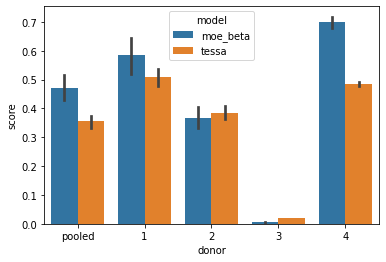

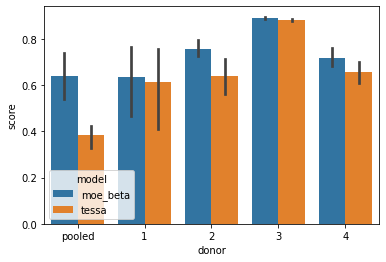

In [64]:
import seaborn as sb
import matplotlib.pyplot as plt

for met in ['NMI', 'Prediction test']:
    res_tmp = results_full[results_full['metric']==met]
    #res_tmp = res_tmp[res_tmp['donor'].isin([3, 4, 'pooled'])]
    sb.barplot(data=res_tmp, x='donor', y='score', hue='model')
    plt.show()

In [29]:
results_10x

,model,split,metric,score,donor,dataset
0,concat,0,Prediction test,0.867726,None,10x
1,concat,0,NMI,0.476483,None,10x
2,moe,0,Prediction test,0.845823,None,10x
3,moe,0,NMI,0.528413,None,10x
4,poe,0,Prediction test,0.835327,None,10x
...,...,...,...,...,...,...
245,poe,4,NMI,0.475811,4,10x
246,tcr,4,Prediction test,0.754774,4,10x
247,tcr,4,NMI,0.575606,4,10x
248,rna,4,Prediction test,0.455179,4,10x


## Minervina Tests

In [69]:
def load_minervina_model(adata, dataset, split):
    path_model = f'saved_models/journal_2/minervina/beta/'
    path_model += f'minervina_split_{split}_moe_beta'
    path_model += '.pt'
    model = utils.load_model(adata, path_model)
    return model

In [72]:
from sklearn.preprocessing import OneHotEncoder
def load_minervina_data(split):
    adata = utils.load_data('minervina/01_annotated_data.h5ad')

    # subsample to get statistics
    random_seed = split
    adata.obs['group_col'] = [seq[1:-1] for seq in adata.obs['IR_VDJ_1_junction_aa']]
    train_val, test = group_shuffle_split(adata, group_col='group_col', val_split=0.20, random_seed=random_seed)
    train, val = group_shuffle_split(train_val, group_col='group_col', val_split=0.25, random_seed=random_seed)

    adata.obs['set'] = None
    adata.obs.loc[train.obs.index, 'set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'val'
    adata.obs.loc[test.obs.index, 'set'] = 'test'
    return adata

In [74]:
dataset = 'minervina'
metadata = ['epitope']

splits = []
metrics = []
scores = []

for split in tqdm(range(0, 5)):
    data = load_minervina_data(split)
    model = load_minervina_model(data, dataset, split)
    test_embedding_func = get_model_prediction_function(model)
    for source in ['test']:  #, 'val']:
        summary = run_imputation_evaluation(data, test_embedding_func, query_source=source,
                                    label_pred='epitope')
        result = summary['knn']['weighted avg']['f1-score']

        splits.append(split)
        metrics.append(f'Prediction {source}')
        scores.append(result)
        donors.append(donor)

    best_nmi = -99
    for resolution in [0.01, 0.1, 1.0]:
        cluster_result = run_clustering_evaluation(data, test_embedding_func, 'train', name_label='epitope', 
                                           cluster_params={'resolution': resolution, 'num_neighbors': 5})
        best_nmi = max(cluster_result['NMI'], best_nmi)
    splits.append(split)
    metrics.append('NMI')
    scores.append(best_nmi)  

results_min = {
    'model': ['moe_beta'] * len(splits),
    'split': splits,
    'metric': metrics,
    'score': scores,
    'donor': ['-'] * len(splits),
    'dataset': [dataset] * len(splits)
}
results_min = pd.DataFrame(results_min)
results_min.to_csv(f'../results/performance_minervina_beta.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.72s/it]


In [75]:
results_min

,model,split,metric,score,donor,dataset
0,moe_beta,0,Prediction test,0.785889,-,minervina
1,moe_beta,0,NMI,0.429266,-,minervina
2,moe_beta,1,Prediction test,0.750811,-,minervina
3,moe_beta,1,NMI,0.403444,-,minervina
4,moe_beta,2,Prediction test,0.789553,-,minervina
5,moe_beta,2,NMI,0.446035,-,minervina
6,moe_beta,3,Prediction test,0.803089,-,minervina
7,moe_beta,3,NMI,0.449326,-,minervina
8,moe_beta,4,Prediction test,0.767579,-,minervina
9,moe_beta,4,NMI,0.433344,-,minervina


In [77]:
results_min_tessa = pd.read_csv('../results/performance_tessa_minervina.csv', index_col=0)
results_min_tessa['dataset'] = 'minervina'
results_min_tessa['donor'] = '-'
results_min_tessa

,model,split,metric,score,dataset,donor
0,tessa,0,Prediction test,0.483462,minervina,-
1,tessa,0,NMI,0.317480,minervina,-
2,tessa,1,Prediction test,0.490160,minervina,-
3,tessa,1,NMI,0.290917,minervina,-
4,tessa,2,Prediction test,0.445630,minervina,-
5,tessa,2,NMI,0.308612,minervina,-
6,tessa,3,Prediction test,0.450989,minervina,-
7,tessa,3,NMI,0.315509,minervina,-
8,tessa,4,Prediction test,0.460254,minervina,-
9,tessa,4,NMI,0.300247,minervina,-


In [78]:
results_full = pd.concat([results_min, results_min_tessa])

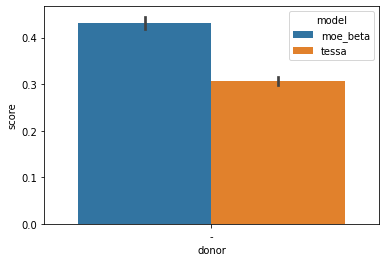

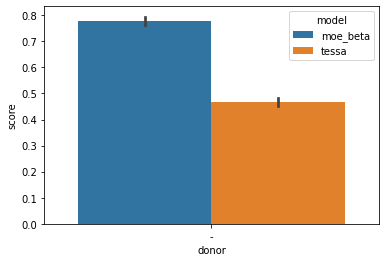

In [79]:
import seaborn as sb
import matplotlib.pyplot as plt
for met in ['NMI', 'Prediction test']:
    res_tmp = results_full[results_full['metric']==met]
    sb.barplot(data=res_tmp, x='donor', y='score', hue='model')
    plt.show()

In [34]:
results_min.groupby(['model', 'metric'])['score'].mean()

model   metric         
concat  NMI                0.416252
        Prediction test    0.775144
moe     NMI                0.433374
        Prediction test    0.789407
poe     NMI                0.385350
        Prediction test    0.736544
rna     NMI                0.401746
        Prediction test    0.770900
tcr     NMI                0.352971
        Prediction test    0.634417
Name: score, dtype: float64

## Cell characteristics

In [24]:
def load_covid_data(split):
    adata = utils.load_data('covid')
    random_seed = split
    sub, non_sub = group_shuffle_split(adata, group_col='clonotype', val_split=0.2, random_seed=random_seed)
    train, val = group_shuffle_split(sub, group_col='clonotype', val_split=0.20, random_seed=random_seed)
    
    adata.obs['set'] = 'train'
    adata.obs.loc[non_sub.obs.index, 'set'] = '-'
    adata.obs.loc[val.obs.index, 'set'] = 'val'
    adata = adata[adata.obs['set'].isin(['train', 'val'])]
    return adata

## Write Supplemantary Material S1

In [ ]:
raise ValueError

In [ ]:
path_out = '../results/supplement/S1_benchmarking.xlsx'

with pd.ExcelWriter(path_out, mode='a') as writer:  
    results_10x_tessa.to_excel(writer, sheet_name='moe_beta_10x')
    results_tessa_characteristics.to_excel(writer, sheet_name='moe_beta_characteristics')